In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
import numpy as np
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.options.display.max_columns = None

In [3]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Function

In [4]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [5]:
def compute_last_local_max(series: pd.Series) -> pd.Series:
    """
    Per ogni indice i, restituisce il valore (non l'indice) dell’ultimo massimo locale
    avvenuto in un giorno j < i, con definizione:
    
    - j=0 è un massimo locale se series[0] > series[1].
    - per 0 < j < len(series)-1, j è massimo locale se:
        series[j] >= series[j-1] e series[j] >= series[j+1]
    - l’ultimo giorno (j = len-1) non viene considerato un massimo locale.
    
    Ritorna una Series 'last_local_max' tale che:
       last_local_max[i] = series[j]  (dove j è l’ultimo massimo locale con j < i)
       se non esiste j < i che sia un massimo locale, last_local_max[i] = NaN
    """
    arr = series.values
    n = len(arr)
    
    # Array booleana per marcare i massimi locali
    is_local_max = np.zeros(n, dtype=bool)
    
    if n == 1:
        # Con un solo punto non si può definire un massimo locale nel senso classico.
        # Ritorniamo una serie di NaN.
        return pd.Series([np.nan], index=series.index)
    
    # Controllo per il primo indice
    if arr[0] > arr[1]:
        is_local_max[0] = True
    
    # Controllo per l'intervallo [1..n-2]
    # (l'ultimo indice n-1 non si considera per la definizione di massimo locale)
    for i in range(1, n-1):
        if arr[i] >= arr[i-1] and arr[i] >= arr[i+1]:
            is_local_max[i] = True
    
    # Costruiamo la serie che, per ogni i, dice "valore dell'ultimo max locale avvenuto prima di i"
    last_local_max = np.full(n, np.nan)
    
    last_max_value = np.nan
    
    for i in range(n):
        # Se i è un massimo locale, aggiorniamo last_max_value
        if is_local_max[i]:
            last_max_value = arr[i]
        
        last_local_max[i] = last_max_value
    
    return pd.Series(last_local_max, index=series.index)

In [6]:
def liquidity_out_function(current_liquidity: float, coef_liquidity_out:float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando 
    TUTTE le crypto sono in discesa (M.A. < ultimo max locale).
    Aumentiamo la liquidità in base al modulo della variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    new_liquidity = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

In [7]:
def liquidity_in_function(current_liquidity: float, coef_liquidity_in: float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando
    ALMENO UNA crypto è in salita (M.A. >= ultimo max locale).
    Riduciamo la liquidità in base alla variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    # if variation_percent_ma in [0, None] and coef_liquidity_in == np.inf:
    #     return 0
    
    new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

In [8]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

# Strategia

In [9]:
def portfolio_value(prices_row: pd.Series, quantities_dict: dict, liquidity_amount: float) -> float:
    """
    Calcola il valore totale del portafoglio (sommando le crypto e la liquidità).
    """
    total = liquidity_amount
    for c in quantities_dict.keys():
        total += quantities_dict[c] * prices_row[c]
    return total

In [10]:
def trova_massimi_minimi_locali(series: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dati i valori di 'series', individua i massimi e minimi locali secondo la regola:
    
    - Per i = 0 (primo elemento), se series[0] > series[1], allora series[0] è un massimo locale.
      Se series[0] <= series[1], allora series[0] è un minimo locale.
    - Per 0 < i < len(series) - 1:
        * massimi se series[i-1] < series[i] > series[i+1]
        * minimi se series[i-1] > series[i] < series[i+1]
    - L'ultimo elemento (i = len(series)-1) non viene considerato per definizione.
    
    Ritorna due pd.Series (massimi, minimi) dove i valori sono NaN se non è un estremo locale,
    oppure il valore della series se è un massimo/minimo locale.
    """
    n = len(series)
    
    massimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    minimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    
    if n == 0 or n == 1:
        # Con un solo punto o nessuno, non possiamo definire un massimo o minimo locale
        return massimi, minimi
    
    # Gestione del primo elemento (i=0)
    if n >= 2:
        if series.iloc[0] > series.iloc[1]:
            massimi.iloc[0] = series.iloc[0]
        else:
            minimi.iloc[0] = series.iloc[0]
    
    # Gestione degli elementi intermedi (1 .. n-2)
    for i in range(1, n-1):
        if (series.iloc[i-1] < series.iloc[i] > series.iloc[i+1]):
            massimi.iloc[i] = series.iloc[i]
        elif (series.iloc[i-1] > series.iloc[i] < series.iloc[i+1]):
            minimi.iloc[i] = series.iloc[i]
    
    # L'ultimo elemento (i = n-1) non lo consideriamo come massimo o minimo locale
    
    return massimi, minimi

In [11]:
def trova_ultimo_estremo_locale(series: pd.Series,
                               massimi: pd.Series,
                               minimi: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dato un vettore 'series' e i suoi 'massimi' e 'minimi' locali (come restituiti da
    trova_massimi_minimi_locali), costruisce due Series:
      - last_ext_type: 'max' o 'min' (oppure None/NaN se non c'è stato ancora un estremo)
      - last_ext_value: valore dell'ultimo estremo locale incontrato finora (NaN se nessuno)
    
    Esempio: per i=0, last_ext_type[0] è 'max' se massimi[0] non è NaN, 
             'min' se minimi[0] non è NaN, altrimenti None.
    """
    n = len(series)
    last_ext_type_arr = [None]*n
    last_ext_value_arr = [None]*n
    
    current_type = None
    current_value = None
    
    for i in range(n):
        if not pd.isna(massimi.iloc[i]):
            current_type = 'max'
            current_value = massimi.iloc[i]
        elif not pd.isna(minimi.iloc[i]):
            current_type = 'min'
            current_value = minimi.iloc[i]
        
        last_ext_type_arr[i] = current_type
        last_ext_value_arr[i] = current_value
    
    last_ext_type = pd.Series(last_ext_type_arr, index=series.index, dtype=object)
    last_ext_value = pd.Series(last_ext_value_arr, index=series.index, dtype=float)
    return last_ext_type, last_ext_value

In [12]:
def func_liquidity_out(current_liquidity: float,
                           coef_liquidity_out: float,
                           variation_percent_ma: float) -> float:
    """
    Aumenta la liquidità in base al coefficiente e alla variazione percentuale (assoluta).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_out == np.inf and variation_percent_ma == 0:
        return 1

    new_liquidity_pct = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    return min(max(new_liquidity_pct, 0), 1)

In [13]:
def func_liquidity_in(current_liquidity: float,
                          coef_liquidity_in: float,
                          variation_percent_ma: float) -> float:
    """
    Riduce la liquidità in base al coefficiente e alla variazione percentuale (positiva).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_in == np.inf and variation_percent_ma == 0:
        return 0

    new_liquidity_pct = current_liquidity - coef_liquidity_in * variation_percent_ma
    return min(max(new_liquidity_pct, 0), 1)

In [14]:
def grid_search_rebalancing(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        print(f"Inizio iterazione {idx + 1}/{len(grid_params)}")
        print(f"Parametri: {params}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy(
                dati,
                initial_liquidity,
                initial_allocations,
                params['timeframe'],
                params['ma_window'],
                params['weighting_factor'],
                params['coef_liquidity_out'],
                params['coef_liquidity_in'],
                params['dynamical_variables'],
                params['window_grid_search']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df

In [45]:
def simulate_trading_strategy(
    crypto_prices: pd.DataFrame,
    initial_liquidity: float,
    initial_allocations: dict,
    timeframe: int,
    ma_window: int,
    weighting_factor: float,
    coef_liquidity_out: float,
    coef_liquidity_in: float,
    dynamical_variables: dict,
    window_grid_search: int
) -> pd.DataFrame:
    """
    Simula una strategia di trading su un insieme di crypto. Logica:
      - Se *tutte* le crypto hanno come ultimo estremo locale un massimo ('down'),
        usiamo la differenza tra la colonna MA_avg_price_return e il suo ultimo max locale.
      - Se *almeno una* crypto ha ultimo estremo locale un minimo ('up'),
        usiamo la differenza tra la 'media mobile della media dei prezzi delle sole crypto up'
        e il suo ultimo min locale (tutto precalcolato in una passata vettoriale).
      - Ribilanciamo ogni 'timeframe' giorni. 
      - La % di liquidità si aggiusta con func_liquidity_out/func_liquidity_in (qui supponiamo 
        siano funzioni globali o già definite).
      - Infine, ribilanciamo le crypto secondo weighting_factor (M.A. normalizzate vs 100% su max).

    Parametri
    ---------
    crypto_prices : pd.DataFrame
        Indice=timestamp, colonne=crypto (es. 'BTC', 'ETH'...).
    initial_liquidity : float
        Liquidità iniziale.
    initial_allocations : dict
        Es. {'BTC':0.3, 'ETH':0.5, 'liquidity':0.2} => somma=1.
    timeframe : int
        Ogni quante giornate ribilanciare.
    ma_window : int
        Finestra rolling per calcolo media mobile.
    weighting_factor : float
        Peso per mixare M.A. normalizzate vs 100% su M.A. max o 100% su M.A. min.
    coef_liquidity_out : float
        Param per la funzione 'func_liquidity_out'.
    coef_liquidity_in : float
        Param per la funzione 'func_liquidity_in'.
    dynamical_variables: dict
        Dizionario che ha come chiavi i nomi dei parametri che devono cambiare dinamicamente tramite una grid search durante i giorni di ribilanciamento e come valori una lista con i valori da provare per la grid search per il parametro in questione; la grid search viene fatta sul periodo dal precedente ribilanciamento a quello attuale e restituisce i valori migliori in quel periodo per i parametri scelti
    window_grid_search: int
        Rappresenta la finestra di tempo passata su cui fare a posteriori una grid search per vedere quali sarebbero stati i parametri migliori in quel periodo (utile solo se dynamical_variables non è vuoto)

    Ritorna
    -------
    pd.DataFrame
        Con una riga per ciascun giorno di 'crypto_prices'.
        Colonne: 
          - timestamp
          - liquidity, portfolio_value
          - average_price, avg_price_return, MA_avg_price_return
          - price_{c}, qty_{c}, value_{c}, MA_{c}
          - last_ext_type_{c}, last_ext_value_{c}
          - last_ext_type_avg, last_ext_value_avg
          - sub_avg_up (media dei prezzi delle crypto "up" di quel giorno)
          - sub_return_up, MA_sub_return_up, last_ext_type_sub_up, last_ext_value_sub_up
    """

    # -------------------------------------------------------------------
    # 1) PRECALCOLI (massimi/minimi, medie mobili) - TUTTO FUORI DAL LOOP
    # -------------------------------------------------------------------

    # Copia e sort
    prices_df = crypto_prices.copy()
    prices_df.sort_index(inplace=True)

    # Variazione giornaliera
    daily_returns = prices_df.pct_change()

    # M.A. di ogni crypto
    ma_columns = {}
    for col in prices_df.columns:
        ma_col = f"MA_{col}"
        prices_df[ma_col] = daily_returns[col].rolling(window=ma_window).mean()
        ma_columns[col] = ma_col

    # average_price e relative var
    prices_df["average_price"] = prices_df[crypto_prices.columns].mean(axis=1)
    prices_df["avg_price_return"] = prices_df["average_price"].pct_change()
    prices_df["MA_avg_price_return"] = prices_df["avg_price_return"].rolling(window=ma_window).mean()

    # Troviamo massimi/minimi locali per:
    #   - la colonna MA_avg_price_return
    #   - le colonne MA_{crypto}
    # e memorizziamo last_ext_type_{crypto}, last_ext_value_{crypto}

    massimi_avg, minimi_avg = trova_massimi_minimi_locali(prices_df["MA_avg_price_return"])
    ltype_avg, lval_avg = trova_ultimo_estremo_locale(prices_df["MA_avg_price_return"], massimi_avg, minimi_avg)
    prices_df["last_ext_type_avg"] = ltype_avg
    prices_df["last_ext_value_avg"] = lval_avg

    # Per ogni crypto
    for c in prices_df.columns:
        if not c.startswith("MA_"):
            continue
        crypto_name = c.replace("MA_", "")
        massimi_c, minimi_c = trova_massimi_minimi_locali(prices_df[c])
        lt_c, lv_c = trova_ultimo_estremo_locale(prices_df[c], massimi_c, minimi_c)
        prices_df[f"last_ext_type_{crypto_name}"] = lt_c
        prices_df[f"last_ext_value_{crypto_name}"] = lv_c

    # 2) Precalcolo "sub_avg_up" = media dei prezzi delle crypto "up" in ciascun giorno
    #    e relativa var, M.A., massimi/minimi. 
    #    2a) Per ogni giorno, identifichiamo le crypto up => up_cryptos[t] = ...
    #    2b) Facciamo la media (tra le N crypto up) dei prezzi di quelle crypto => colonna sub_avg_up
    #    2c) Calcoliamo sub_return_up = pct_change(sub_avg_up), poi la rolling => MA_sub_return_up
    #    2d) Troviamo massimi/minimi => last_ext_type_sub_up, last_ext_value_sub_up
    # Per efficienza, facciamo tutto in maniera "vettoriale":

    # Passo 2a-2b: costruiamo un DataFrame booleano is_up[c, t] che vale True se last_ext_type_{c}[t]=='min'
    # e False altrimenti. Poi, per ogni riga t, prendiamo i prezzi di tutte le crypto "up".
    # Infine facciamo la media su quell'insieme. 
    # => usiamo la formula: sub_avg_up[t] = ( sum_{c in up} price[t, c] ) / (count_{c in up}).
    # Avviene in modo "trick" con .where + count:

    crypto_list = [x for x in crypto_prices.columns]  # Tutte le crypto
    up_bool_df = pd.DataFrame(False, index=prices_df.index, columns=crypto_list)

    for c in crypto_list:
        # se last_ext_type_{c} == 'min' => è up
        ctype_series = prices_df[f"last_ext_type_{c}"]
        up_bool_df[c] = (ctype_series == 'min')

    # Adesso costruiamo sub_avg_up come la media, per riga, dei prezzi (solo dove up_bool_df==True).
    # Un modo: 
    # sum_of_up_prices[t] = sum( price[t, c] * 1_{up} ), 
    # n_up[t] = sum( 1_{up} ), 
    # sub_avg_up[t] = sum_of_up_prices[t] / n_up[t].
    # (Attenzione a n_up[t] = 0 => sub_avg_up=NaN).
    arr_prices = prices_df[crypto_list].values  # shape (N, M)
    arr_up_bool = up_bool_df.values  # shape (N, M)

    sum_up = (arr_prices * arr_up_bool).sum(axis=1)  # shape (N,)
    count_up = arr_up_bool.sum(axis=1)  # shape (N,)

    with np.errstate(invalid='ignore', divide='ignore'): # Per evitare i runtime warning in caso di divisione per 0
        sub_avg_up = sum_up / count_up

    sub_avg_up[count_up == 0] = np.nan  # se 0 crypto up => sub_avg_up = NaN

    prices_df["sub_avg_up"] = sub_avg_up

    # 2c) sub_return_up = pct_change(sub_avg_up), MA_sub_return_up
    prices_df["sub_return_up"] = prices_df["sub_avg_up"].pct_change()
    prices_df["MA_sub_return_up"] = prices_df["sub_return_up"].rolling(window=ma_window).mean()

    # 2d) massimi/minimi locali su "MA_sub_return_up"
    massimi_sub, minimi_sub = trova_massimi_minimi_locali(prices_df["MA_sub_return_up"])
    ltype_sub, lval_sub = trova_ultimo_estremo_locale(prices_df["MA_sub_return_up"], massimi_sub, minimi_sub)
    prices_df["last_ext_type_sub_up"] = ltype_sub
    prices_df["last_ext_value_sub_up"] = lval_sub

    # -------------------------------------------------------------------
    # FINE PRECALCOLI
    # -------------------------------------------------------------------

    # Inizializziamo il portafoglio
    # (stessa logica di prima)
    crypto_alloc = [k for k in initial_allocations.keys() if k.lower() != "liquidity"]
    if not np.isclose(sum(initial_allocations.values()), 1.0):
        raise ValueError(f"La somma delle allocazioni iniziali deve essere 1.0 e invece è {sum(initial_allocations.values())}: {initial_allocations}")

    current_quantities = {c:0.0 for c in crypto_alloc}
    current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0)
    if np.isclose(current_liquidity, 0):
        current_liquidity = 0

    # Prezzi del primo giorno
    first_date = prices_df.index[0]
    first_row = prices_df.loc[first_date, crypto_alloc]
    for c in crypto_alloc:
        perc = initial_allocations[c]
        p = first_row[c]
        cap = initial_liquidity*perc
        if pd.notna(p) and p!=0:
            current_quantities[c] = cap/p
        else:
            current_quantities[c] = 0.0

    # -------------------------------------------------------------------
    # 3) LOOP PRINCIPALE (i calcoli di M.A., massimi/minimi, sub-up sono già pronti)
    # -------------------------------------------------------------------

    records = []
    # Potenziale micro-ottimizzazione: iterare con itertuples
    #   for row in prices_df.itertuples():
    # Ma qui preferiamo rimanere più chiari: usiamo enumerate(prices_df.index).

    idx_array = prices_df.index.to_list()
    for i, dt in enumerate(idx_array):
        row_prices = prices_df.loc[dt, crypto_alloc]
        pv = portfolio_value(row_prices, current_quantities, current_liquidity)
        # print('Valore portafoglio:', pv)

        if np.isclose(current_liquidity, 0):
            current_liquidity = 0

        # Salvataggio riga
        rec = {
            "timestamp": dt,
            "liquidity": current_liquidity,
            "portfolio_value": pv,
            "average_price": prices_df.loc[dt,"average_price"],
            "avg_price_return": prices_df.loc[dt,"avg_price_return"],
            "MA_avg_price_return": prices_df.loc[dt,"MA_avg_price_return"],
            "sub_avg_up": prices_df.loc[dt,"sub_avg_up"],
            "sub_return_up": prices_df.loc[dt,"sub_return_up"],
            "MA_sub_return_up": prices_df.loc[dt,"MA_sub_return_up"],
        }

        for c in crypto_alloc:
            price_c = row_prices[c]
            qty_c = current_quantities[c]
            rec[f"price_{c}"] = price_c
            rec[f"qty_{c}"] = qty_c
            rec[f"value_{c}"] = price_c*qty_c if pd.notna(price_c) else np.nan

            # M.A. colonna
            ma_c = ma_columns[c]
            rec[f"MA_{c}"] = prices_df.loc[dt, ma_c]
            rec[f"last_ext_type_{c}"] = prices_df.loc[dt,f"last_ext_type_{c}"]
            rec[f"last_ext_value_{c}"] = prices_df.loc[dt,f"last_ext_value_{c}"]

        rec["last_ext_type_avg"] = prices_df.loc[dt,"last_ext_type_avg"]
        rec["last_ext_value_avg"] = prices_df.loc[dt,"last_ext_value_avg"]
        rec["last_ext_type_sub_up"] = prices_df.loc[dt,"last_ext_type_sub_up"]
        rec["last_ext_value_sub_up"] = prices_df.loc[dt,"last_ext_value_sub_up"]

        records.append(rec)

        # Ogni timeframe giorni => ribilanciamento
        if i>0 and (i % timeframe==0):
            # Aggiorno parametri dinamici
            if len(dynamical_variables) > 0:
                # Mi salvo tutti i valori di default da assegnare per i parametri non presenti in dynamical_variables
                default_parameters = {'timeframe':timeframe, 'ma_window':ma_window, 'weighting_factor':weighting_factor, 'coef_liquidity_out':coef_liquidity_out, 'coef_liquidity_in':coef_liquidity_in, 'dynamical_variables':{}, 'window_grid_search':window_grid_search} # Devo fare la grid search con le variabili statiche, quindi devo assegnare un dizionario vuoto a dynamical_variables (altrimenti mi farebbe un loop infinito tra l'altro)
                for parameter_name in default_parameters.keys():
                    if not parameter_name in dynamical_variables.keys():
                        dynamical_variables[parameter_name] = [default_parameters[parameter_name]]
                # Controllo che in dynamical_variables non ci siano features ulteriori inesistenti:
                if len(dynamical_variables) != len(default_parameters):
                    raise ValueError('Qualcosa non va con il dizionario dynamical_variables! Probabilmente sono state aggiunte delle feature inesistenti...')
                sort_quantity = 'fattore_rendimento_totale'
                # Dizionario dei parametri per la grid search
                param_grid = dynamical_variables.copy()

                # Genera tutte le combinazioni di parametri
                grid_params = list(ParameterGrid(param_grid))

                skip_conditions = [False] * len(grid_params)
                window_grid_search = min(window_grid_search, i) # Se ancora non ci sono window_grid_search dati nel passato, uso "i" al posto di window_grid_search
                # Ricostruisco l'allocazione "iniziale" che avevo window_grid_search dati prima
                temp_initial_allocations = {
                crypto: (records[i - window_grid_search]['liquidity'] / records[i - window_grid_search]['portfolio_value']
                        if crypto == 'liquidity'
                        else records[i - window_grid_search][f'value_{crypto}'] / records[i - window_grid_search]['portfolio_value'])
                for crypto in initial_allocations.keys()
                }
                print('temp_initial_allocations:', temp_initial_allocations)
                print(f'Sto per fare la grid search del dato {i}...')
                risultati_df_ordinati = grid_search_rebalancing(crypto_prices.iloc[i-window_grid_search:i], grid_params, temp_initial_allocations, records[i-window_grid_search]['portfolio_value'], skip_conditions, sort_quantity) # Come liquidità iniziale devo passare in realtà il portafoglio totale perchè poi nella strategia ottengo la vera liquidità dividendo il totale per le varie allocazioni (inclusa quella della liquidità)
                best_row = risultati_df_ordinati.iloc[0]
                print(f'Migliori parametri (e {sort_quantity}) trovati per il periodo {i-window_grid_search}-{i}:\n{best_row}')
                timeframe, ma_window, weighting_factor, coef_liquidity_out, coef_liquidity_in = best_row['timeframe'], best_row['ma_window'], best_row['weighting_factor'], best_row['coef_liquidity_out'], best_row['coef_liquidity_in']

            # Determiniamo se all_down o some_up
            all_down = True
            at_least_one_up = False

            # Se troviamo almeno una crypto con last_ext_type=='min', => up
            for c in crypto_alloc:
                ext_type = prices_df.loc[dt,f"last_ext_type_{c}"]
                if ext_type=='min':
                    at_least_one_up = True
                    all_down=False
                    break
                elif pd.isna(ext_type) or ext_type is None:
                    all_down=False

            variation_percent_ma=0.0
            if all_down:
                # prendo differenza tra MA_avg_price_return e last_ext_value_avg
                lv = prices_df.loc[dt,"last_ext_value_avg"]
                cm = prices_df.loc[dt,"MA_avg_price_return"]
                if (pd.notna(lv) and lv!=0 and pd.notna(cm)):
                    variation_percent_ma=(cm-lv)/lv
                new_liq_pct = func_liquidity_out(
                    current_liquidity/pv if pv!=0 else 0,
                    coef_liquidity_out,
                    variation_percent_ma
                )
            elif at_least_one_up:
                # prendo differenza tra MA_sub_return_up e last_ext_value_sub_up
                lv_sub = prices_df.loc[dt,"last_ext_value_sub_up"]
                cm_sub = prices_df.loc[dt,"MA_sub_return_up"]
                if (pd.notna(lv_sub) and lv_sub!=0 and pd.notna(cm_sub)):
                    variation_percent_ma=(cm_sub-lv_sub)/lv_sub
                new_liq_pct = func_liquidity_in(
                    current_liquidity/pv if pv!=0 else 0,
                    coef_liquidity_in,
                    variation_percent_ma
                )
            else:
                # caso neutro
                new_liq_pct = current_liquidity/pv if pv!=0 else 0

            # Ribilanciamento
            total_before = portfolio_value(row_prices, current_quantities, current_liquidity)
            # vendiamo tutto
            to_sell=0.0
            for c in crypto_alloc:
                p_ = row_prices[c]
                if pd.notna(p_) and p_>0:
                    to_sell += current_quantities[c]*p_
                current_quantities[c]=0
            current_liquidity+=to_sell

            # Nuova % liq => new_liq_pct => new_liq_amount
            new_liq_amount=total_before*new_liq_pct
            crypto_amount=total_before-new_liq_amount

            # 1) Ricaviamo il segno e alpha
            sign_w = 1.0 if weighting_factor >= 0 else -1.0
            alpha = abs(weighting_factor)

            # Leggiamo le M.A. in un dict "ma_values"
            ma_values = {}
            for c in crypto_alloc:
                val = prices_df.loc[dt, ma_columns[c]]
                if pd.isna(val):
                    val = 0
                ma_values[c] = val

            # 2) Verifichiamo quante M.A. >= 0 e quante < 0
            count_pos = sum(1 for c in crypto_alloc if ma_values[c] >= 0)
            count_neg = len(crypto_alloc) - count_pos

            # 3) Decidiamo se filtrare positive o negative:
            #    - Se weighting_factor >= 0 e c'è almeno una M.A. >= 0 => uso le M.A. >=0
            #      altrimenti uso le M.A. negative
            #    - Se weighting_factor < 0 e c'è almeno una M.A. < 0 => uso le M.A. <0
            #      altrimenti uso le M.A. >= 0
            use_positive = False
            use_negative = False

            if sign_w >= 0:
                # weighting_factor >= 0 => preferiremmo M.A. >=0
                if count_pos > 0:
                    use_positive = True
                else:
                    use_negative = True
            else:
                # weighting_factor < 0 => preferiremmo M.A. <0
                if count_neg > 0:
                    use_negative = True
                else:
                    use_positive = True

            # 4) Creiamo ma_filtered in base alla scelta
            ma_filtered = {}
            for c in crypto_alloc:
                v = ma_values[c]
                if use_positive and v >= 0:
                    ma_filtered[c] = v
                elif use_negative and v < 0:
                    ma_filtered[c] = v
                else:
                    ma_filtered[c] = 0

            # 5) Calcoliamo la somma di ma_filtered
            s_ = sum(ma_filtered.values())

            # 6) Se la somma è ~0 => partial_dict_ma = uniform, altrimenti normalizziamo
            if np.isclose(s_, 0):
                partial_dict_ma = {c: 1.0/len(crypto_alloc) for c in crypto_alloc}
            else:
                partial_dict_ma = {c: (ma_filtered[c]/s_) for c in crypto_alloc}

            # 7) Troviamo la crypto “dominante”
            #    - se weighting_factor >= 0 => max
            #    - se weighting_factor < 0  => min
            if weighting_factor >= 0:
                # "dominante" = M.A. più grande tra le scelte
                # se tutte 0, pazienza => max_c a caso, partial_extreme avrà 1.0 su di essa
                max_c = max(crypto_alloc, key=lambda x: ma_filtered[x])
                partial_extreme = {c: 0.0 for c in crypto_alloc}
                partial_extreme[max_c] = 1.0
            else:
                # weighting_factor < 0 => "dominante" = M.A. più piccola (più negativa o meno positiva)
                min_c = min(crypto_alloc, key=lambda x: ma_filtered[x])
                partial_extreme = {c: 0.0 for c in crypto_alloc}
                partial_extreme[min_c] = 1.0

            # 8) Creiamo final_dict con la combinazione
            final_dict = {}
            for c in crypto_alloc:
                final_dict[c] = (1 - alpha)*partial_dict_ma[c] + alpha*partial_extreme[c]
                # Devo moltiplicare tutto il dizionario finale per (1 - new_liq_pct) perchè in generale la liquidità percentuale non è 0
                final_dict[c] *= (1 - new_liq_pct)


            # ricompriamo
            for c in crypto_alloc:
                cap_c=crypto_amount*final_dict[c]
                p_ = row_prices[c]
                if pd.notna(p_) and p_>0:
                    qty_=cap_c/p_
                else:
                    qty_=0.0
                current_quantities[c]=qty_
                current_liquidity-=cap_c

            # se la liquidity è < new_liq_amount, vendiamo un po' di crypto
            if current_liquidity<new_liq_amount:
                needed=new_liq_amount-current_liquidity
                updated_pv=portfolio_value(row_prices, current_quantities, current_liquidity)
                non_liq_val=updated_pv-current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_ = row_prices[c]
                        if pd.notna(p_) and p_>0:
                            c_val=current_quantities[c]*p_
                            share_=c_val/non_liq_val
                            to_sell_=needed*share_
                            qty_sell=to_sell_/p_
                            if qty_sell>current_quantities[c]:
                                qty_sell=current_quantities[c]
                            current_quantities[c]-=qty_sell
                            current_liquidity+=to_sell_

    # Creiamo e ritorniamo
    result = pd.DataFrame.from_records(records)
    return result

In [16]:
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
# initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

# crypto_names = ['DOGE', 'AXS']
# initial_allocations = {crypto: 1/len(crypto_names) for crypto in crypto_names}

In [17]:
cryptos = list(crypto for crypto in initial_allocations.keys() if crypto != 'liquidity')  # Specifica le crypto

In [18]:
timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
start_date = '2021-01-01'  # Data di inizio
end_date = '2021-12-31'  # Data di fine
plot = False
market = 'binance'

data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

Scarico i dati per BTC/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per ETH/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per SOL/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per DOGE/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per LINK/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per AXS/USDT dal 2021-01-01 al 2021-12-31...


In [19]:
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[cryptos[0]].index
for crypto in cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values
crypto_prices.set_index('timestamp', inplace=True)

crypto_prices

,BTC,ETH,SOL,DOGE,LINK,AXS
timestamp,,,,,,
2021-01-01 00:00:00,28995.13,734.07,1.5442,0.004679,11.2812,0.53441
2021-01-01 01:00:00,29409.99,748.28,1.5734,0.004737,11.4735,0.53366
2021-01-01 02:00:00,29194.65,744.06,1.5872,0.004755,11.5773,0.53321
2021-01-01 03:00:00,29278.40,744.82,1.6029,0.004978,11.5006,0.54173
2021-01-01 04:00:00,29220.31,742.29,1.6022,0.004894,11.4575,0.53912
...,...,...,...,...,...,...
2021-12-30 20:00:00,47203.16,3724.78,173.1900,0.171100,19.8700,95.08000
2021-12-30 21:00:00,47300.00,3736.93,173.2000,0.171800,19.9900,95.53000
2021-12-30 22:00:00,47084.88,3703.83,171.6800,0.171000,19.8600,94.73000


In [20]:
crypto_prices.mean(axis=1)

timestamp
2021-01-01 00:00:00    4957.094081
2021-01-01 01:00:00    5028.642549
2021-01-01 02:00:00    4992.068744
2021-01-01 03:00:00    5006.145035
2021-01-01 04:00:00    4996.033952
                          ...     
2021-12-30 20:00:00    8536.041850
2021-12-30 21:00:00    8554.303633
2021-12-30 22:00:00    8512.525167
2021-12-30 23:00:00    8519.626850
2021-12-31 00:00:00    8510.280250
Length: 8724, dtype: float64

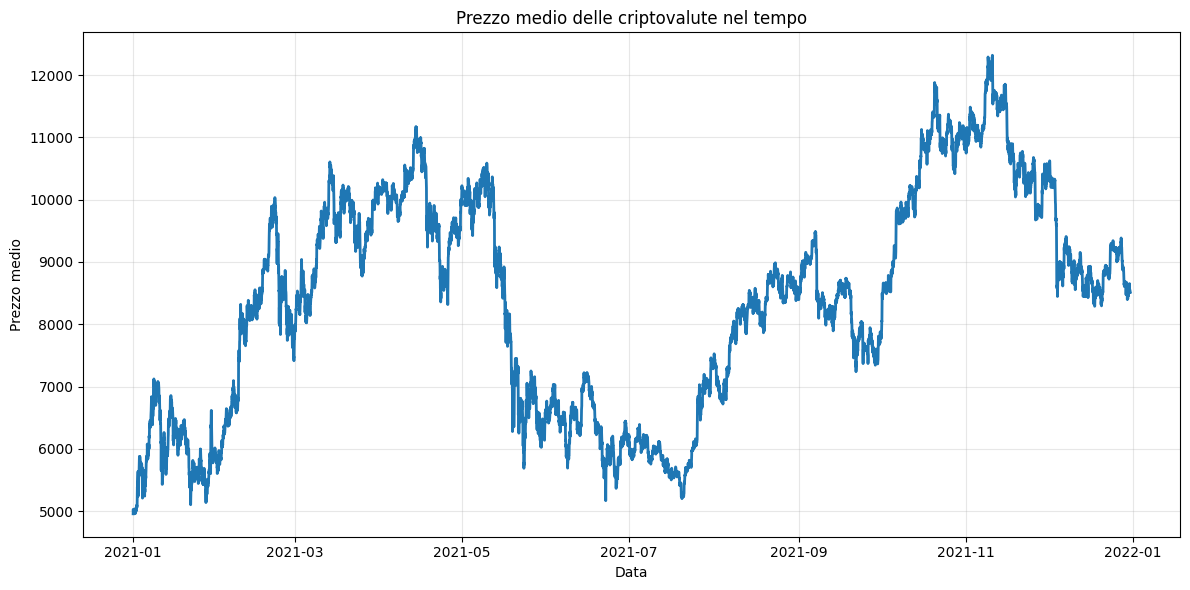

In [21]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices.mean(axis=1), label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [22]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [23]:
# crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
# crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
# crypto_prices.set_index('timestamp', inplace=True)
# crypto_prices

In [24]:
crypto_prices.isna().sum().sum()

0

In [57]:
# Parametri fissi
initial_liquidity = 100

# Parametri variabili
timeframe = 24*14
ma_window = 24*2
weighting_factor = 0
coef_liquidity_out = 0.2
coef_liquidity_in = 0.6
dynamical_variables = {}
window_grid_search = 24*28 # Consigliabile averlo maggiore di timeframe (se "timeframe" non compare in dynamical_variables), perchè altrimenti di fatto la grid search effettua delle mini-simulazioni in cui non ribilancia mai e il fattore di rendimento totale risulterà sempre uguale per tutte le combinazioni della grid search eseguita

df_results = simulate_trading_strategy(crypto_prices, initial_liquidity, initial_allocations, timeframe, ma_window, weighting_factor, coef_liquidity_out, coef_liquidity_in, dynamical_variables, window_grid_search)
df_results

,timestamp,liquidity,portfolio_value,average_price,avg_price_return,MA_avg_price_return,sub_avg_up,sub_return_up,MA_sub_return_up,price_BTC,qty_BTC,value_BTC,MA_BTC,last_ext_type_BTC,last_ext_value_BTC,price_ETH,qty_ETH,value_ETH,MA_ETH,last_ext_type_ETH,last_ext_value_ETH,price_SOL,qty_SOL,value_SOL,MA_SOL,last_ext_type_SOL,last_ext_value_SOL,price_DOGE,qty_DOGE,value_DOGE,MA_DOGE,last_ext_type_DOGE,last_ext_value_DOGE,price_LINK,qty_LINK,value_LINK,MA_LINK,last_ext_type_LINK,last_ext_value_LINK,price_AXS,qty_AXS,value_AXS,MA_AXS,last_ext_type_AXS,last_ext_value_AXS,last_ext_type_avg,last_ext_value_avg,last_ext_type_sub_up,last_ext_value_sub_up
0,2021-01-01 00:00:00,0.000000,100.000000,4957.094081,NaN,NaN,NaN,NaN,NaN,28995.13,0.000575,16.666667,NaN,None,NaN,734.07,0.022704,16.666667,NaN,None,NaN,1.5442,10.793075,16.666667,NaN,None,NaN,0.004679,3562.166937,16.666667,NaN,None,NaN,11.2812,1.477384,16.666667,NaN,None,NaN,0.53441,31.187041,16.666667,NaN,None,NaN,None,NaN,None,NaN
1,2021-01-01 01:00:00,0.000000,101.342501,5028.642549,0.014434,NaN,NaN,NaN,NaN,29409.99,0.000575,16.905132,NaN,None,NaN,748.28,0.022704,16.989297,NaN,None,NaN,1.5734,10.793075,16.981824,NaN,None,NaN,0.004737,3562.166937,16.872204,NaN,None,NaN,11.4735,1.477384,16.950768,NaN,None,NaN,0.53366,31.187041,16.643276,NaN,None,NaN,None,NaN,None,NaN
2,2021-01-01 02:00:00,0.000000,101.477428,4992.068744,-0.007273,NaN,NaN,NaN,NaN,29194.65,0.000575,16.781353,NaN,None,NaN,744.06,0.022704,16.893484,NaN,None,NaN,1.5872,10.793075,17.130769,NaN,None,NaN,0.004755,3562.166937,16.938460,NaN,None,NaN,11.5773,1.477384,17.104120,NaN,None,NaN,0.53321,31.187041,16.629242,NaN,None,NaN,None,NaN,None,NaN
3,2021-01-01 03:00:00,0.000000,102.659037,5006.145035,0.002820,NaN,NaN,NaN,NaN,29278.40,0.000575,16.829493,NaN,None,NaN,744.82,0.022704,16.910740,NaN,None,NaN,1.6029,10.793075,17.300220,NaN,None,NaN,0.004978,3562.166937,17.732823,NaN,None,NaN,11.5006,1.477384,16.990805,NaN,None,NaN,0.54173,31.187041,16.894956,NaN,None,NaN,None,NaN,None,NaN
4,2021-01-01 04:00:00,0.000000,102.115284,4996.033952,-0.002020,NaN,NaN,NaN,NaN,29220.31,0.000575,16.796102,NaN,None,NaN,742.29,0.022704,16.853297,NaN,None,NaN,1.6022,10.793075,17.292665,NaN,None,NaN,0.004894,3562.166937,17.432533,NaN,None,NaN,11.4575,1.477384,16.927130,NaN,None,NaN,0.53912,31.187041,16.813558,NaN,None,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2021-12-30 20:00:00,24866.083828,24866.083828,8536.041850,-0.007428,-0.000272,8536.041850,-0.174403,11.868921,47203.16,0.000000,0.000000,-0.000246,min,-0.000246,3724.78,0.000000,0.000000,-0.000544,min,-0.000544,173.1900,0.000000,0.000000,-0.000911,min,-0.000911,0.171100,0.000000,0.000000,-0.000583,min,-0.000583,19.8700,0.000000,0.000000,-0.001140,min,-0.001140,95.08000,0.000000,0.000000,-0.001265,min,-0.001265,min,-0.000272,min,11.868921
8720,2021-12-30 21:00:00,24866.083828,24866.083828,8554.303633,0.002139,-0.000119,NaN,0.000000,11.887276,47300.00,0.000000,0.000000,-0.000095,max,-0.000095,3736.93,0.000000,0.000000,-0.000367,max,-0.000367,173.2000,0.000000,0.000000,-0.000618,max,-0.000618,0.171800,0.000000,0.000000,-0.000285,max,-0.000285,19.9900,0.000000,0.000000,-0.000559,max,-0.000559,95.53000,0.000000,0.000000,-0.001121,max,-0.001121,max,-0.000119,max,11.887276
8721,2021-12-30 22:00:00,24866.083828,24866.083828,8512.525167,-0.004884,-0.000273,8512.525167,-0.002755,11.424339,47084.88,0.000000,0.000000,-0.000244,min,-0.000244,3703.83,0.000000,0.000000,-0.000571,min,-0.000571,171.6800,0.000000,0.000000,-0.000889,min,-0.000889,0.171000,0.000000,0.000000,-0.000346,min,-0.000346,19.8600,0.000000,0.000000,-0.000796,min,-0.000796,94.73000,0.000000,0.000000,-0.001358,min,-0.001358,min,-0.000273,max,11.887276
8722,2021-12-30 23:00:00,24866.083828,24866.083828,8519.626850,0.000834,-0.000191,95.000000,-0.988840,11.415

In [58]:
df_results['portfolio_value'].iloc[-1] / df_results['portfolio_value'].iloc[0]

248.66083828164992

In [59]:
df_results['portfolio_value'].max() / df_results['portfolio_value'].iloc[0]

277.9967975295945

In [60]:
df_results['portfolio_value'].max(), df_results['portfolio_value'].iloc[-1]

(27799.679752959444, 24866.083828164985)

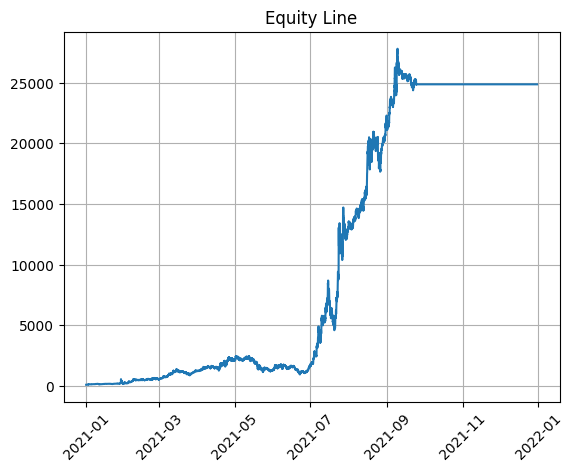

In [61]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(df_results['timestamp'], df_results['portfolio_value']);

In [62]:
mdp.calcola_principali_metriche(prices=df_results['average_price'], bitcoin_posseduti=df_results['liquidity'], portfolio_values=df_results['portfolio_value'])

{'Total Return %': 24766.083828164992,
 'Max Drawdown %': 68.19470819029428,
 'Volatility': 0.3197218658574741,
 'Sharpe Ratio': 0.6511176848535163,
 'Sortino Ratio': 1.1531843209897032,
 'Calmar Ratio': 363.16723812434753,
 'Profit Factor': inf,
 'PnL': 6796131.371728818}

In [38]:
calcola_rendimento_portafoglio_ideale_multicrypto([crypto_prices[crypto] for crypto in initial_allocations.keys() if crypto != 'liquidity'], initial_liquidity, [token_iniziali for token_iniziali in initial_allocations.values()], 0, 0, 0, 0)

[4.283913220607839e+59, 9.620487367455475e+61]

# Grid search

In [31]:
# Parametri fissi
initial_allocations = {'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_liquidity = 100
sort_quantity = 'fattore_rendimento_totale'

In [33]:
# Dizionario dei parametri per la grid search
param_grid = {
    'timeframe': [24, 24*7, 24*14],
    'ma_window': [1, 6, 24, 48, 72, 24*7],
    'weighting_factor': [0, 0.25, 0.5, 0.75, 1],
    'coef_liquidity_out': [0, 1, 5, np.inf],
    'coef_liquidity_in': [0, 1, 5, np.inf],
    'dynamical_variables': [{}],
    'window_grid_search': [24]
}

# Genera tutte le combinazioni di parametri
grid_params = list(ParameterGrid(param_grid))

skip_conditions = []

for comb in grid_params:
    condition = False  
    skip_conditions.append(condition)

# crypto_list = crypto_prices.columns

risultati_df_ordinati = grid_search_rebalancing(crypto_prices, initial_allocations, grid_params, initial_liquidity, skip_conditions, sort_quantity)
risultati_df_ordinati

Inizio iterazione 1/1440
Parametri: {'coef_liquidity_in': 0, 'coef_liquidity_out': 0, 'ma_window': 1, 'timeframe': 24, 'weighting_factor': 0}
Iterazione 1 completata: Fattore Rendimento Totale = 62.64404787249902
Inizio iterazione 2/1440
Parametri: {'coef_liquidity_in': 0, 'coef_liquidity_out': 0, 'ma_window': 1, 'timeframe': 24, 'weighting_factor': 0.25}
Iterazione 2 completata: Fattore Rendimento Totale = 75.97098970144124
Inizio iterazione 3/1440
Parametri: {'coef_liquidity_in': 0, 'coef_liquidity_out': 0, 'ma_window': 1, 'timeframe': 24, 'weighting_factor': 0.5}
Iterazione 3 completata: Fattore Rendimento Totale = 82.14903954652176
Inizio iterazione 4/1440
Parametri: {'coef_liquidity_in': 0, 'coef_liquidity_out': 0, 'ma_window': 1, 'timeframe': 24, 'weighting_factor': 0.75}
Iterazione 4 completata: Fattore Rendimento Totale = 81.2673455994177
Inizio iterazione 5/1440
Parametri: {'coef_liquidity_in': 0, 'coef_liquidity_out': 0, 'ma_window': 1, 'timeframe': 24, 'weighting_factor': 1}

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.0,0.0,48,336,0.00,691.925791,0.335259,68.194708,0.724411,1.304873,1013.166284
1,1.0,0.0,48,336,0.00,633.835039,0.340393,68.194708,0.711042,1.292485,927.982619
2,0.0,0.0,24,336,0.00,614.612833,0.339794,71.156112,0.711131,1.255433,862.347330
3,0.0,0.0,48,336,0.00,595.451063,0.343423,68.194708,0.702508,1.278805,871.696761
4,5.0,0.0,48,336,0.25,570.398452,0.338625,68.718544,0.703818,1.267649,828.595050
...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,5.0,1,168,1.00,1.276890,0.322836,85.883697,0.176125,0.292130,0.322401
1436,5.0,5.0,24,168,1.00,1.266950,0.316379,74.419194,0.172422,0.284254,0.358711
1437,5.0,inf,168,168,1.00,1.239044,0.121085,59.482607,0.112104,0.160221,0.401872
1438,5.0,inf,24,168,1.00,1.140112,0.205241,71.922629,0.121587,0.178541,0.194810


In [34]:
risultati_df_ordinati[(risultati_df_ordinati['weighting_factor'] == 1) & (risultati_df_ordinati['coef_liquidity_in'] == 5) & (risultati_df_ordinati['coef_liquidity_out'] == 1)].sort_values(by='fattore_rendimento_totale', ascending=False)

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
123,5.0,1.0,72,336,1.0,122.040107,0.361778,74.416128,0.557564,0.989766,162.653057
365,5.0,1.0,48,336,1.0,49.594342,0.335481,70.248045,0.495692,0.878660,69.175366
421,5.0,1.0,72,168,1.0,42.999079,0.380819,77.982670,0.469022,0.823458,53.856939
612,5.0,1.0,24,336,1.0,24.240777,0.345055,75.314360,0.432084,0.748700,30.858361
618,5.0,1.0,48,168,1.0,23.665160,0.353384,70.248045,0.428172,0.736356,32.264471
712,5.0,1.0,6,336,1.0,17.204517,0.349109,77.050734,0.399633,0.709779,21.030971
741,5.0,1.0,168,336,1.0,15.094690,0.279895,70.248045,0.411505,0.725178,20.064174
806,5.0,1.0,168,168,1.0,12.248775,0.296107,70.248045,0.384235,0.676227,16.012936
849,5.0,1.0,24,24,1.0,9.992845,0.288364,64.230372,0.370277,0.634721,14.000923
898,5.0,1.0,168,24,1.0,8.357917,0.269592,70.238296,0.352458,0.628404,10.475649


In [48]:
risultati_df_ordinati[risultati_df_ordinati['fattore_rendimento_totale'] > 100]

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.0,0.0,48,336,0.00,691.925791,0.335259,68.194708,0.724411,1.304873,1013.166284
1,1.0,0.0,48,336,0.00,633.835039,0.340393,68.194708,0.711042,1.292485,927.982619
2,0.0,0.0,24,336,0.00,614.612833,0.339794,71.156112,0.711131,1.255433,862.347330
3,0.0,0.0,48,336,0.00,595.451063,0.343423,68.194708,0.702508,1.278805,871.696761
4,5.0,0.0,48,336,0.25,570.398452,0.338625,68.718544,0.703818,1.267649,828.595050
...,...,...,...,...,...,...,...,...,...,...,...
157,0.0,0.0,168,24,0.50,101.436302,0.354477,79.074419,0.549406,0.969549,127.014910
158,5.0,0.0,24,336,0.75,101.384622,0.343172,71.226109,0.553949,0.975689,140.937956
159,0.0,0.0,24,168,0.00,100.979539,0.337020,69.293489,0.559529,0.965951,144.284174
160,0.0,1.0,72,168,0.00,100.534490,0.327303,68.926951,0.563940,0.980096,144.405764


In [60]:
risultati_df_ordinati[risultati_df_ordinati['fattore_rendimento_totale'] > 100][risultati_df_ordinati[risultati_df_ordinati['fattore_rendimento_totale'] > 100]['coef_liquidity_in'] > 9999]

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
36,1.000000e+09,0.0,6,336,0.00,245.290840,0.339484,71.249603,0.630560,1.125462,342.866246
62,1.000000e+09,0.0,6,336,0.25,187.554419,0.342345,71.255001,0.604889,1.083502,261.812388
75,1.000000e+09,0.0,48,168,0.00,166.648216,0.305002,68.194708,0.630365,1.094171,242.904795
81,1.000000e+09,0.0,48,336,0.00,158.786158,0.314794,68.194708,0.615575,1.082906,231.375956
95,1.000000e+09,5.0,48,24,0.25,147.788746,0.312751,55.450482,0.610821,1.082256,264.720415
99,1.000000e+09,5.0,48,24,0.00,143.810723,0.305270,54.769843,0.615864,1.089601,260.747002
100,1.000000e+09,0.0,48,168,0.25,143.381722,0.311730,68.718544,0.609157,1.058487,207.195488
105,1.000000e+09,5.0,48,24,0.50,140.665553,0.323193,56.122993,0.596589,1.060132,248.856207
110,1.000000e+09,0.0,6,336,0.50,136.437277,0.348802,71.286235,0.572989,1.031768,189.990784
115,1.000000e+09,0.0,48,336,0.25,130.138582,0.318411,68.718544,0.593849,1.044812,187.923921


In [58]:
risultati_df_ordinati[risultati_df_ordinati['fattore_rendimento_totale'] > 100]['coef_liquidity_in'].median()

1.0

In [57]:
risultati_df_ordinati[risultati_df_ordinati['fattore_rendimento_totale'] > 100].median()

coef_liquidity_in              1.000000
coef_liquidity_out             0.000000
ma_window                     48.000000
timeframe                    336.000000
weighting_factor               0.250000
fattore_rendimento_totale    159.645958
volatility                     0.342524
max_drawdown                  70.306431
sharpe_ratio                   0.599883
sortino_ratio                  1.058275
calmar_ratio                 235.565943
dtype: float64

In [36]:
risultati_df_ordinati[:50]

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.0,0.0,48,336,0.00,691.925791,0.335259,68.194708,0.724411,1.304873,1013.166284
1,1.0,0.0,48,336,0.00,633.835039,0.340393,68.194708,0.711042,1.292485,927.982619
2,0.0,0.0,24,336,0.00,614.612833,0.339794,71.156112,0.711131,1.255433,862.347330
3,0.0,0.0,48,336,0.00,595.451063,0.343423,68.194708,0.702508,1.278805,871.696761
4,5.0,0.0,48,336,0.25,570.398452,0.338625,68.718544,0.703818,1.267649,828.595050
5,1.0,0.0,24,336,0.00,554.640306,0.337210,71.130021,0.705191,1.243825,778.349700
6,5.0,0.0,72,24,1.00,542.141630,0.387553,72.738922,0.655906,1.170872,743.950573
7,1.0,0.0,48,336,0.25,527.021352,0.343765,68.718544,0.691655,1.257018,765.472204
8,1.0,0.0,72,24,1.00,524.623368,0.391020,73.857551,0.651144,1.160380,708.963891
9,0.0,0.0,48,336,0.25,497.312897,0.346771,68.718544,0.683797,1.244510,722.240125


In [37]:
risultati_df_ordinati[-50:]

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
1390,1.0,inf,24,168,0.75,1.626140,0.174475,68.746514,0.168660,0.242800,0.910795
1391,0.0,5.0,72,24,0.75,1.624569,0.084900,28.469632,0.207549,0.303217,2.193807
1392,0.0,1.0,72,24,0.75,1.624569,0.084900,28.469632,0.207549,0.303217,2.193807
1393,0.0,inf,48,168,0.50,1.614471,0.060174,25.115556,0.260316,0.364358,2.446574
1394,1.0,inf,48,24,0.75,1.612859,0.101171,32.437102,0.186326,0.287382,1.889376
1395,0.0,5.0,48,24,0.75,1.611627,0.095021,32.437102,0.192509,0.284614,1.885578
1396,0.0,5.0,24,24,0.25,1.611451,0.073193,21.994358,0.225237,0.340196,2.780034
1397,0.0,inf,24,24,0.25,1.611451,0.073193,21.994358,0.225237,0.340196,2.780034
1398,1.0,inf,168,168,0.75,1.603637,0.097345,34.376839,0.188951,0.274996,1.755940
1399,0.0,inf,168,24,0.25,1.602612,0.068728,28.051837,0.232827,0.326183,2.148208


In [38]:
risultati_df_ordinati['fattore_rendimento_totale'].mean(), risultati_df_ordinati['fattore_rendimento_totale'].median(), risultati_df_ordinati['fattore_rendimento_totale'].min(), risultati_df_ordinati['fattore_rendimento_totale'].max(), risultati_df_ordinati['fattore_rendimento_totale'].std()

(43.715046637012605,
 16.637267851243458,
 0.8232677243871801,
 691.9257908960558,
 74.78618909652221)

In [39]:
risultati_df_ordinati.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.0,0.0,48,336,0.00,691.925791,0.335259,68.194708,0.724411,1.304873,1013.166284
1,0.0,0.0,24,336,0.00,614.612833,0.339794,71.156112,0.711131,1.255433,862.347330
2,1.0,0.0,48,336,0.00,633.835039,0.340393,68.194708,0.711042,1.292485,927.982619
3,1.0,0.0,24,336,0.00,554.640306,0.337210,71.130021,0.705191,1.243825,778.349700
4,5.0,0.0,48,336,0.25,570.398452,0.338625,68.718544,0.703818,1.267649,828.595050
...,...,...,...,...,...,...,...,...,...,...,...
1435,5.0,inf,168,168,0.50,1.388869,0.110499,55.348289,0.141609,0.199754,0.702586
1436,5.0,inf,168,168,0.75,1.312790,0.115379,57.445397,0.126290,0.179250,0.544500
1437,0.0,inf,1,168,1.00,0.823268,0.301891,85.883697,0.125091,0.202690,-0.205781
1438,5.0,inf,24,168,1.00,1.140112,0.205241,71.922629,0.121587,0.178541,0.194810


In [40]:
risultati_df_ordinati.sort_values(by='sortino_ratio', ascending=False).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.0,0.0,48,336,0.00,691.925791,0.335259,68.194708,0.724411,1.304873,1013.166284
1,1.0,0.0,48,336,0.00,633.835039,0.340393,68.194708,0.711042,1.292485,927.982619
2,0.0,0.0,48,336,0.00,595.451063,0.343423,68.194708,0.702508,1.278805,871.696761
3,5.0,0.0,48,336,0.25,570.398452,0.338625,68.718544,0.703818,1.267649,828.595050
4,1.0,0.0,48,336,0.25,527.021352,0.343765,68.718544,0.691655,1.257018,765.472204
...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,inf,1,168,1.00,0.823268,0.301891,85.883697,0.125091,0.202690,-0.205781
1436,5.0,inf,168,168,0.50,1.388869,0.110499,55.348289,0.141609,0.199754,0.702586
1437,5.0,inf,168,168,0.75,1.312790,0.115379,57.445397,0.126290,0.179250,0.544500
1438,5.0,inf,24,168,1.00,1.140112,0.205241,71.922629,0.121587,0.178541,0.194810


In [41]:
risultati_df_ordinati.sort_values(by='calmar_ratio', ascending=False).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.0,0.0,48,336,0.00,691.925791,0.335259,68.194708,0.724411,1.304873,1013.166284
1,1.0,0.0,48,336,0.00,633.835039,0.340393,68.194708,0.711042,1.292485,927.982619
2,0.0,0.0,48,336,0.00,595.451063,0.343423,68.194708,0.702508,1.278805,871.696761
3,0.0,0.0,24,336,0.00,614.612833,0.339794,71.156112,0.711131,1.255433,862.347330
4,5.0,0.0,48,336,0.25,570.398452,0.338625,68.718544,0.703818,1.267649,828.595050
...,...,...,...,...,...,...,...,...,...,...,...
1435,5.0,5.0,24,168,1.00,1.266950,0.316379,74.419194,0.172422,0.284254,0.358711
1436,0.0,1.0,1,168,1.00,1.276890,0.322836,85.883697,0.176125,0.292130,0.322401
1437,0.0,5.0,1,168,1.00,1.276890,0.322836,85.883697,0.176125,0.292130,0.322401
1438,5.0,inf,24,168,1.00,1.140112,0.205241,71.922629,0.121587,0.178541,0.194810


In [42]:
risultati_df_ordinati.sort_values(by='max_drawdown', ascending=True).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,ma_window,timeframe,weighting_factor,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.0,inf,6,168,0.75,1.490675,0.045412,12.336576,0.276915,0.396328,3.977398
1,0.0,inf,6,168,0.50,1.490675,0.045412,12.336576,0.276915,0.396328,3.977398
2,0.0,inf,6,168,0.25,1.490675,0.045412,12.336576,0.276915,0.396328,3.977398
3,0.0,inf,6,168,1.00,1.490675,0.045412,12.336576,0.276915,0.396328,3.977398
4,0.0,inf,6,168,0.00,1.490675,0.045412,12.336576,0.276915,0.396328,3.977398
...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,0.0,168,24,1.00,105.684035,0.409384,85.831842,0.526316,0.954188,121.964102
1436,0.0,0.0,1,168,1.00,2.876137,0.360997,85.883697,0.258002,0.449135,2.184509
1437,0.0,1.0,1,168,1.00,1.276890,0.322836,85.883697,0.176125,0.292130,0.322401
1438,0.0,5.0,1,168,1.00,1.276890,0.322836,85.883697,0.176125,0.292130,0.322401


# Machine learning per trovare relazioni tra parametri e target

In [43]:
def train_random_forest_regressor(
    df_risultati_ordinati,
    feature_cols,
    target_col,
    test_size=0.2,
    random_state=42,
    # Parametri generici della RandomForest (valori di default)
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    # Valore numerico limite per sostituire np.inf
    max_val=1e9
):
    """
    Allena una RandomForestRegressor per predire 'target_col' (continuo) 
    a partire da 'feature_cols'. Sostituisce eventuali valori np.inf / -np.inf con +/- max_val.
    Mostra le importanze delle feature (anche graficamente).

    Parametri
    ---------
    df_risultati_ordinati : pd.DataFrame
        Il DataFrame con i dati (colonne di parametri e colonna target).
    feature_cols : list
        Lista di nomi di colonne da usare come feature (parametri).
    target_col : str
        Nome della colonna target (es. 'fattore_rendimento_totale').
    test_size : float
        Percentuale di dati nel test set (default 0.2 = 20%).
    random_state : int
        Seed per la riproducibilità.
    n_estimators : int
        Numero di alberi nella foresta. Default=100.
    criterion : str
        Funzione di split ('squared_error', 'absolute_error', ecc.).
    max_depth : int
        Profondità massima degli alberi, None = illimitata.
    min_samples_split : int
        Min numero di campioni per dividere un nodo.
    min_samples_leaf : int
        Min numero di campioni in un leaf node.
    min_weight_fraction_leaf : float
        Min frazione peso sample in un leaf node.
    max_features : str/int/float
        Numero di feature da considerare a ogni split.
    max_leaf_nodes : int
        Numero massimo di leaf nodes.
    min_impurity_decrease : float
        Soglia per ridurre la crescita del nodo se non migliora l'impurity.
    bootstrap : bool
        Usa il bootstrap per il campionamento.
    oob_score : bool
        Se True, calcola lo score out-of-bag.
    n_jobs : int
        Numero di job in parallelo (None=1, -1=usa tutti i core).
    verbose : int
        Livello di verbosità.
    warm_start : bool
        Se True, riusa la soluzione dell'albero precedente per addestrare uno nuovo.
    ccp_alpha : float
        Parametro di complessità di potatura Minimal Cost-Complexity.
    max_samples : int/float
        Se bootstrap=True, numero o frazione di campioni da campionare a ogni albero.
    max_val : float
        Valore con cui sostituire np.inf e -np.inf.

    Ritorna
    -------
    model : RandomForestRegressor
        Il modello allenato.
    """
    # Sostituiamo np.inf e -np.inf con +/- max_val
    for col in feature_cols:
        df_risultati_ordinati[col] = df_risultati_ordinati[col].replace([float('inf')], max_val)
        df_risultati_ordinati[col] = df_risultati_ordinati[col].replace([-float('inf')], -max_val)

    # Selezioniamo le feature e il target
    X = df_risultati_ordinati[feature_cols]
    y = df_risultati_ordinati[target_col]

    # Suddivisione train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Inizializziamo il modello di Random Forest Regressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples
    )

    # Fit del modello
    model.fit(X_train, y_train)

    # Predizione sul test set
    y_pred = model.predict(X_test)

    # Metriche di valutazione
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"R^2 (test):  {r2:.4f}")
    print(f"RMSE (test): {rmse:.4f}")

    # Feature importances
    importances = model.feature_importances_
    importances_pct = 100.0 * (importances / importances.sum())

    feats_imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'importance_pct': importances_pct
    }).sort_values('importance', ascending=True)

    print("\nFeature Importances (valore assoluto e percentuale):")
    display(feats_imp.sort_values('importance', ascending=False))

    # Plot orizzontale delle importanze (percentuali)
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('Random Forest Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return model

building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s


building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tree 209 of 1000
building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000
building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tre

[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    1.5s


building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000
building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tre

[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    2.8s


building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tre

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s


R^2 (test):  0.8482
RMSE (test): 22.6782

Feature Importances (valore assoluto e percentuale):


,feature,importance,importance_pct
1,ma_window,0.303029,30.302888
3,coef_liquidity_out,0.269955,26.995506
0,timeframe,0.175577,17.557730
4,coef_liquidity_in,0.134654,13.465389
2,weighting_factor,0.116785,11.678487


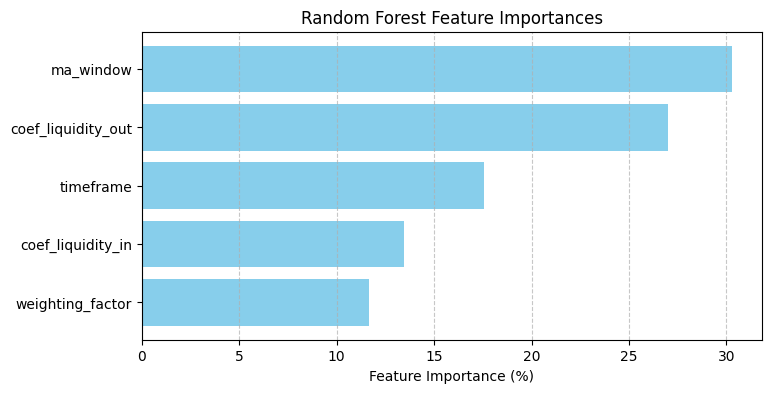

In [44]:
# Esempio di utilizzo (adatta i nomi di colonna):
rf_model = train_random_forest_regressor(
    risultati_df_ordinati,
    feature_cols=['timeframe', 'ma_window', 'weighting_factor', 'coef_liquidity_out', 'coef_liquidity_in'],
    target_col='fattore_rendimento_totale',
    test_size=0.2,
    random_state=42,
    n_estimators=1000,
    max_depth=None,
    verbose = 2,
    max_val = 1e9,
    # max_features = None
)